# Practice 12 — Optimization Techniques

Original Authors: Seungjae Ryan Lee, Ki Hyun Kim
Source: https://github.com/deeplearningzerotoall/PyTorch

같은 모델이라도 **최적화 기법**에 따라 성능이 크게 달라집니다.

| 기법 | 핵심 |
|------|------|
| 데이터 전처리 | 스케일 통일 → 학습 안정 |
| 가중치 초기화 | Xavier / He |
| 옵티마이저 | SGD → Adam |
| 활성 함수 | ReLU (gradient vanishing 해결) |
| 배치 정규화 | 층별 분포 안정화 |

In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

# 데이터 로드 + 분할 + 표준화
digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

mu = X_train.mean(0)
sigma = X_train.std(0) + 1e-8
X_train_s = (X_train - mu) / sigma
X_test_s = (X_test - mu) / sigma

train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_train_s), torch.LongTensor(y_train)),
    batch_size=64, shuffle=True)
test_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_test_s), torch.LongTensor(y_test)),
    batch_size=64)

print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

Train: 1437, Test: 360


In [17]:
# 모델을 학습하고 epoch별 (loss, accuracy) 리스트를 반환합니다.
def train(model, train_loader, test_loader, optimizer, epochs=30):
    criterion = nn.CrossEntropyLoss()
    losses = []  # train loss
    accs = []    # test accuracy

    for epoch in range(epochs):
        # 훈련
        model.train()
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            output = model(X_batch)
            loss = criterion(output, Y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))

        # 테스트 정확도
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                output = model(X_batch)
                correct += (output.argmax(1) == Y_batch).sum().item()
                total += len(Y_batch)
        accs.append(correct / total)

    return losses, accs

---
# 1. 데이터 전처리 (Data Preprocessing)

특징의 스케일이 다르면 경사하강법이 지그재그로 수렴합니다.
표준화: $x_i^{\text{new}} = (x_i - \mu_i) / \sigma_i$

효과를 보기 위해 **일부 특징의 스케일을 100배로 키운** 데이터로 실험합니다.

In [35]:
# 스케일 불균형 데이터 생성: 앞 32개 특징을 20배로
X_skewed = X.copy()
X_skewed[:, :32] *= 20

Xsk_tr, Xsk_te, _, _ = train_test_split(
    X_skewed, y, test_size=0.2, random_state=42, stratify=y)

# 표준화
sk_mu = Xsk_tr.mean(0)
sk_std = Xsk_tr.std(0) + 1e-8
Xsk_tr_s = (Xsk_tr - sk_mu) / sk_std
Xsk_te_s = (Xsk_te - sk_mu) / sk_std

# DataLoader
raw_train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(Xsk_tr), torch.LongTensor(y_train)),
    batch_size=64, shuffle=True)
raw_test_loader = DataLoader(
    TensorDataset(torch.FloatTensor(Xsk_te), torch.LongTensor(y_test)),
    batch_size=64)

std_train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(Xsk_tr_s), torch.LongTensor(y_train)),
    batch_size=64, shuffle=True)
std_test_loader = DataLoader(
    TensorDataset(torch.FloatTensor(Xsk_te_s), torch.LongTensor(y_test)),
    batch_size=64)

print(f'Raw mean and std: {Xsk_tr.mean():.0f}, {Xsk_tr.std():.0f}')
print(f'Scaled mean and std: {Xsk_tr_s.mean():.0f}, {Xsk_tr_s.std():.0f}')

Raw mean and std: 52, 97
Scaled mean and std: 0, 1


Raw (skewed)  -> Test Acc: 0.600
Standardized  -> Test Acc: 0.931


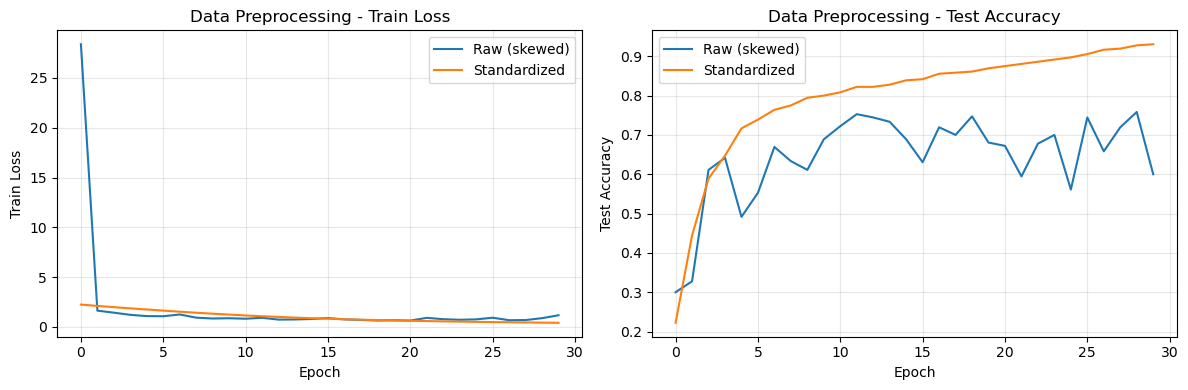

스케일이 다르면 SGD가 수렴하지 못합니다. 표준화는 필수 전처리입니다.


In [36]:
# === Raw (표준화 없음) ===
torch.manual_seed(42)
model_raw = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 10))
optimizer_raw = torch.optim.SGD(model_raw.parameters(), lr=0.01)
losses_raw, accs_raw = train(model_raw, raw_train_loader, raw_test_loader, optimizer_raw)

# === Standardized (표준화) ===
torch.manual_seed(42)
model_std = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 10))
optimizer_std = torch.optim.SGD(model_std.parameters(), lr=0.01)
losses_std, accs_std = train(model_std, std_train_loader, std_test_loader, optimizer_std)

print(f'Raw (skewed)  -> Test Acc: {accs_raw[-1]:.3f}')
print(f'Standardized  -> Test Acc: {accs_std[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses_raw, label='Raw (skewed)')
axes[0].plot(losses_std, label='Standardized')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Train Loss')
axes[0].set_title('Data Preprocessing - Train Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(accs_raw, label='Raw (skewed)')
axes[1].plot(accs_std, label='Standardized')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Data Preprocessing - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('스케일이 다르면 SGD가 수렴하지 못합니다. 표준화는 필수 전처리입니다.')

---
# 2. 가중치 초기화 (Weight Initialization)

| 방법 | 설명 | 적합한 활성 함수 |
|------|------|------|
| Zero | $w = 0$ (사용 금지 — 대칭성) | - |
| He (Kaiming) | $N(0, 2/n_{in})$ | ReLU |

**8층 깊은 네트워크 + SGD**에서 초기화의 차이를 확인합니다.

Large Random init -> Test Acc: 0.856
He init   -> Test Acc: 0.950


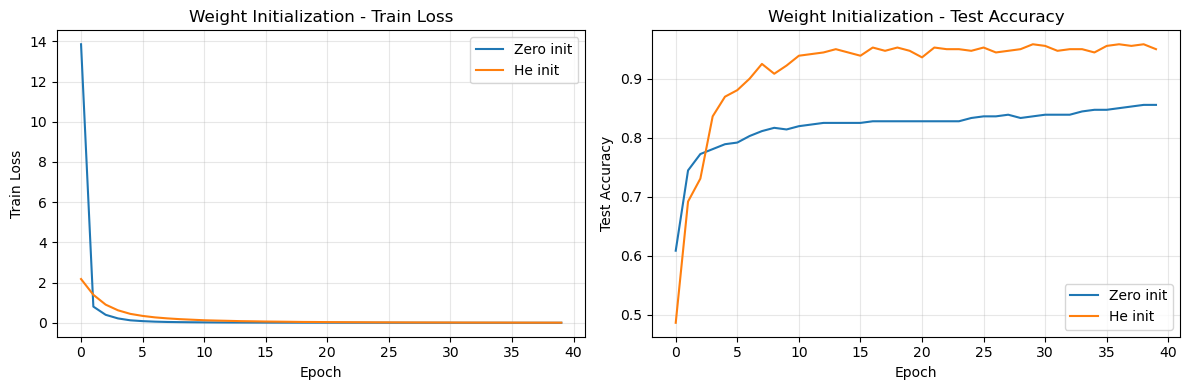

큰 Random 초기화는 학습이 되지 않습니다. He 초기화를 사용하세요.


: 

In [ ]:
# === Zero 초기화 (8층) ===
torch.manual_seed(42)
model_large_random = nn.Sequential(
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 10)
)
for layer in model_large_random:
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0.0, std=0.2)  # 큰 랜덤값으로 초기화
        nn.init.normal_(layer.bias, mean=0.0, std=0.2)  # 큰 랜덤값으로 초기화
optimizer_zero = torch.optim.SGD(model_large_random.parameters(), lr=0.01)
losses_zero, accs_zero = train(model_large_random, train_loader, test_loader, optimizer_zero, epochs=40)

# === He (Kaiming) 초기화 (8층) ===
torch.manual_seed(42)
model_he = nn.Sequential(
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 10)
)
for layer in model_he:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_he = torch.optim.SGD(model_he.parameters(), lr=0.01)
losses_he, accs_he = train(model_he, train_loader, test_loader, optimizer_he, epochs=40)

print(f'Large Random init -> Test Acc: {accs_zero[-1]:.3f}')
print(f'He init   -> Test Acc: {accs_he[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses_zero, label='Zero init')
axes[0].plot(losses_he, label='He init')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Train Loss')
axes[0].set_title('Weight Initialization - Train Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(accs_zero, label='Zero init')
axes[1].plot(accs_he, label='He init')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Weight Initialization - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('큰 Random 초기화는 학습이 되지 않습니다. He 초기화를 사용하세요.')

---
# 3. 옵티마이저 비교 (Optimizer Comparison)

| 옵티마이저 | 설명 |
|---|---|
| SGD | $\theta \leftarrow \theta - \rho \nabla J$ |
| Adam | 1차 + 2차 모멘트로 적응적 학습률 |

SGD (lr=0.01)  -> Test Acc: 0.900
Adam (lr=0.001) -> Test Acc: 0.981


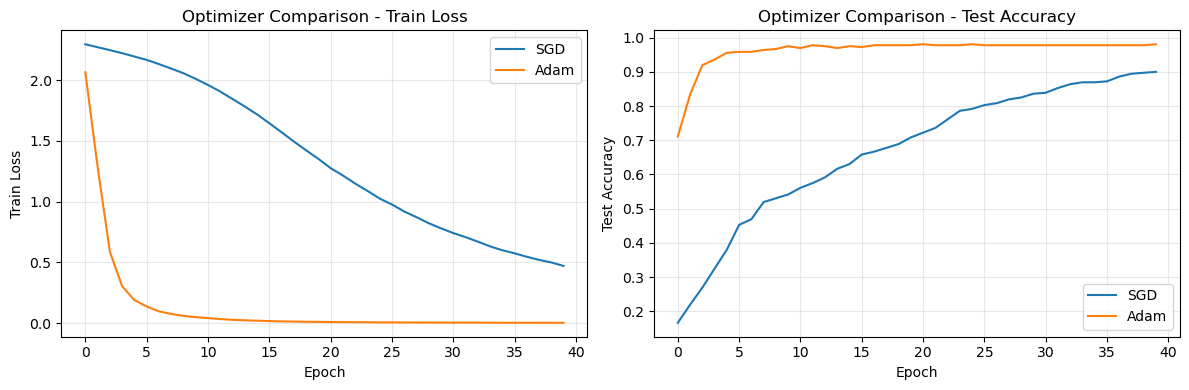

Adam은 적응적 학습률로 SGD보다 빠르게 수렴합니다.


In [21]:
# === SGD ===
torch.manual_seed(42)
model_sgd = nn.Sequential(
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10)
)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01)
losses_sgd, accs_sgd = train(model_sgd, train_loader, test_loader, optimizer_sgd, epochs=40)

# === Adam ===
torch.manual_seed(42)
model_adam = nn.Sequential(
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10)
)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)
losses_adam, accs_adam = train(model_adam, train_loader, test_loader, optimizer_adam, epochs=40)

print(f'SGD (lr=0.01)  -> Test Acc: {accs_sgd[-1]:.3f}')
print(f'Adam (lr=0.001) -> Test Acc: {accs_adam[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses_sgd, label='SGD')
axes[0].plot(losses_adam, label='Adam')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Train Loss')
axes[0].set_title('Optimizer Comparison - Train Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(accs_sgd, label='SGD')
axes[1].plot(accs_adam, label='Adam')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Optimizer Comparison - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('Adam은 적응적 학습률로 SGD보다 빠르게 수렴합니다.')

---
# 4. 활성 함수 (Activation Functions)

Sigmoid/Tanh는 $|z|$가 커지면 gradient → 0 (**포화**).
ReLU: $\max(0, z)$ — 포화 없이 빠른 학습.

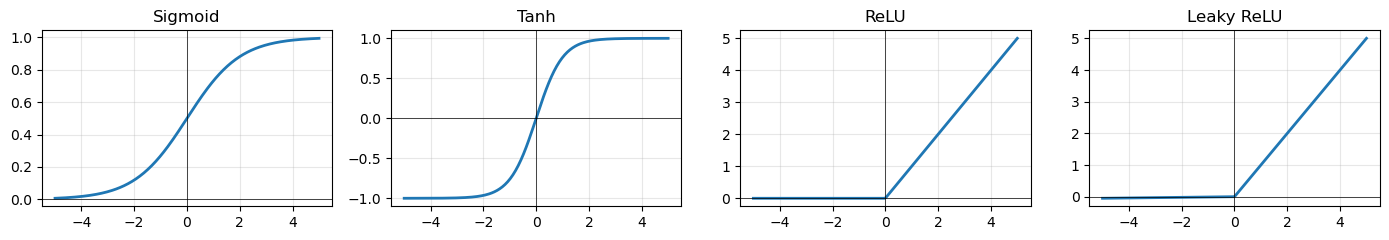

In [22]:
# 활성 함수 그래프
z = np.linspace(-5, 5, 200)
fig, axes = plt.subplots(1, 4, figsize=(14, 2.5))

axes[0].plot(z, 1 / (1 + np.exp(-z)), linewidth=2)
axes[0].set_title('Sigmoid')

axes[1].plot(z, np.tanh(z), linewidth=2)
axes[1].set_title('Tanh')

axes[2].plot(z, np.maximum(0, z), linewidth=2)
axes[2].set_title('ReLU')

axes[3].plot(z, np.where(z > 0, z, 0.01 * z), linewidth=2)
axes[3].set_title('Leaky ReLU')

for ax in axes:
    ax.grid(alpha=0.3)
    ax.axhline(0, color='k', lw=0.5)
    ax.axvline(0, color='k', lw=0.5)
plt.tight_layout(); plt.show()

Sigmoid -> Test Acc: 0.772
ReLU    -> Test Acc: 0.975


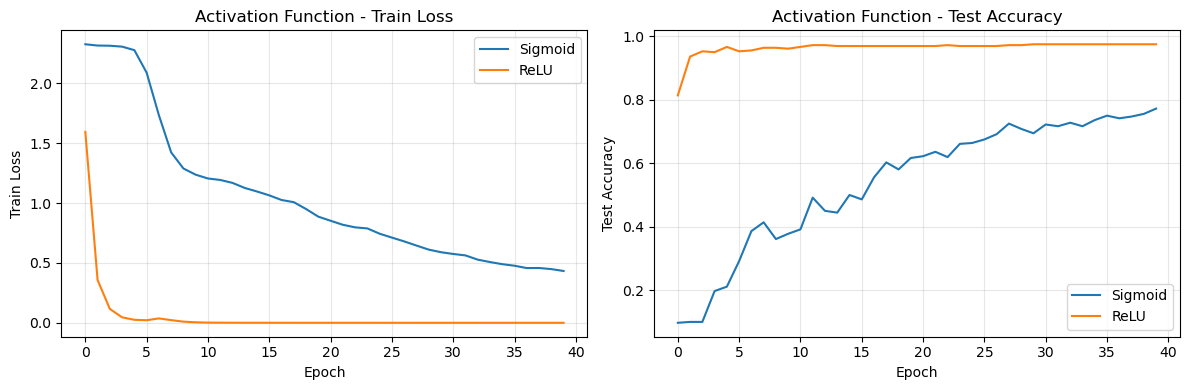

깊은 네트워크에서 Sigmoid는 gradient vanishing으로 학습이 안 됩니다.


In [23]:
# === Sigmoid (8층) ===
torch.manual_seed(42)
model_sig = nn.Sequential(
    nn.Linear(64, 128), nn.Sigmoid(),
    nn.Linear(128, 128), nn.Sigmoid(),
    nn.Linear(128, 128), nn.Sigmoid(),
    nn.Linear(128, 128), nn.Sigmoid(),
    nn.Linear(128, 128), nn.Sigmoid(),
    nn.Linear(128, 128), nn.Sigmoid(),
    nn.Linear(128, 128), nn.Sigmoid(),
    nn.Linear(128, 10)
)
# Sigmoid에는 Xavier 초기화가 적합
for layer in model_sig:
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
optimizer_sig = torch.optim.Adam(model_sig.parameters(), lr=0.001)
losses_sig, accs_sig = train(model_sig, train_loader, test_loader, optimizer_sig, epochs=40)

# === ReLU (8층) ===
torch.manual_seed(42)
model_relu = nn.Sequential(
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 10)
)
# ReLU에는 He 초기화가 적합
for layer in model_relu:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=0.001)
losses_relu, accs_relu = train(model_relu, train_loader, test_loader, optimizer_relu, epochs=40)

print(f'Sigmoid -> Test Acc: {accs_sig[-1]:.3f}')
print(f'ReLU    -> Test Acc: {accs_relu[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses_sig, label='Sigmoid')
axes[0].plot(losses_relu, label='ReLU')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Train Loss')
axes[0].set_title('Activation Function - Train Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(accs_sig, label='Sigmoid')
axes[1].plot(accs_relu, label='ReLU')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Activation Function - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('깊은 네트워크에서 Sigmoid는 gradient vanishing으로 학습이 안 됩니다.')

---
# 5. 배치 정규화 (Batch Normalization)

각 층 출력을 미니배치 단위로 정규화 → 학습 안정화, 더 큰 학습률 사용 가능.

$$\hat{z}_i = \frac{z_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}, \quad z'_i = \gamma \hat{z}_i + \beta$$

**높은 학습률(SGD lr=0.1)**에서 BatchNorm의 안정화 효과를 확인합니다.

Without BN -> Test Acc: 0.969
With BN    -> Test Acc: 0.989


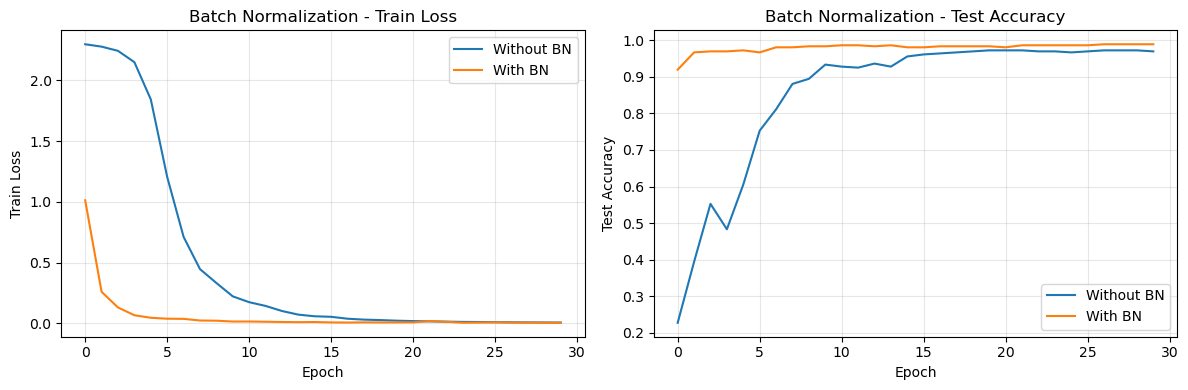

BatchNorm을 사용하면 높은 learning rate에서도 안정적으로 수렴합니다.
주의: model.train()에서는 배치 통계, model.eval()에서는 이동평균 사용


In [24]:
# === Without BatchNorm ===
torch.manual_seed(42)
model_no_bn = nn.Sequential(
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer_no_bn = torch.optim.SGD(model_no_bn.parameters(), lr=0.1)
losses_no_bn, accs_no_bn = train(model_no_bn, train_loader, test_loader, optimizer_no_bn)

# === With BatchNorm ===
torch.manual_seed(42)
model_bn = nn.Sequential(
    nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
    nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
    nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
    nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer_bn = torch.optim.SGD(model_bn.parameters(), lr=0.1)
losses_bn, accs_bn = train(model_bn, train_loader, test_loader, optimizer_bn)

print(f'Without BN -> Test Acc: {accs_no_bn[-1]:.3f}')
print(f'With BN    -> Test Acc: {accs_bn[-1]:.3f}')

# 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses_no_bn, label='Without BN')
axes[0].plot(losses_bn, label='With BN')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Train Loss')
axes[0].set_title('Batch Normalization - Train Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(accs_no_bn, label='Without BN')
axes[1].plot(accs_bn, label='With BN')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Batch Normalization - Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()
print('BatchNorm을 사용하면 높은 learning rate에서도 안정적으로 수렴합니다.')
print('주의: model.train()에서는 배치 통계, model.eval()에서는 이동평균 사용')

---
### 연습 문제

1. 옵티마이저 비교에 `SGD + Momentum 0.9`를 추가해 보세요.
2. 가중치 초기화 비교에서 `nn.init.xavier_uniform_`을 사용해 보세요.
3. (도전) 배치 정규화 실험을 lr=0.001, 0.01, 0.1에서 반복하고, BN이 큰 학습률에서 얼마나 유리한지 보여주세요.

In [25]:
# 연습 문제 풀이 공간

